# Dogs and Cats classifier
## DM873 / DS809 project

Balázs András Tolnai (batol20@student.sdu.dk) (DM873)

Christian Tim Michael Goldapp (chgol20@student.sdu.dk) (DM873)

Christian Skjerning (cskje16@student.sdu.dḱ) (DS809)


In [1]:
!pip install keras h5py ipyplot
%matplotlib inline
%load_ext tensorboard

     |████████████████████████████████| 25.9 MB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 269 kB 20.5 MB/s eta 0:00:01
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=45919 sha256=370b01e9e5f032cdf98cb73270b172282c5ab45d5996a275add52313f9a13580
  Stored in directory: /root/.cache/pip/wheels/e5/9d/ad/2ee53cf262cba1ffd8afe1487eef788ea3f260b7e6232a80fc
Successfully built pyyaml
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os, datetime, shutil
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from keras import layers

from tensorboard import notebook
from IPython.core.display import Image, display
import ipyplot

import matplotlib.pyplot as plt

from tensorboard.plugins.custom_scalar import layout_pb2
from tensorboard.summary.v1 import custom_scalar_pb

print (f'TF version: {tf.__version__}')

TF version: 2.3.1


In [3]:
DATASET_ROOT = 'dataset'
CLASSES = ['cat', 'dog']
DATA_DIR = os.path.join(DATASET_ROOT, 'dataset')
FULL_DATA_DIR = os.path.join(DATASET_ROOT, 'full_dataset')
TRAIN_DATA_DIR = os.path.join(DATASET_ROOT, 'train')
VAL_DATA_DIR = os.path.join(DATASET_ROOT, 'validation')
TEST_DATA_DIR = os.path.join(DATASET_ROOT, 'test')

## Construct datasets
1. Fetch list of all images in dataset
2. Split the list into the two classes: cats and dogs
3. Split each class into training, validation and testing subdatasets
4. Copy the original images/blobs into the new directories

In [4]:
def copy_file(origin, dest):
    # Make sure directory exists while copying
    dest_dir = os.path.dirname(os.path.abspath(dest))
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    shutil.copyfile(origin, dest)

def construct_datasets(val_ratio, test_ratio):
    
    # Remove any existing directories
    for _dir in [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR, FULL_DATA_DIR]:
        if os.path.exists(_dir):
            shutil.rmtree(_dir)
    
    files = os.listdir(DATA_DIR)
    np.random.shuffle(files)
    
    subsets = list()
    for _class in CLASSES:
        subsets.append(list(filter(lambda img_name: _class in img_name, files)))
                       
    for _class, subset in zip(CLASSES, subsets):
        for f in subset:
            from_path = os.path.join(DATA_DIR, f)
            to_path   = os.path.join(FULL_DATA_DIR, f'{_class}s', f)
            copy_file(from_path, to_path)
        
        train, val, test = np.split(subset, [int(len(subset)* (1 - (val_ratio + test_ratio))), int(len(subset)* (1 - test_ratio))])
        
        for _subset, _dir in zip([train, val, test], [TRAIN_DATA_DIR, VAL_DATA_DIR, TEST_DATA_DIR]):
            # Copy files to their respective subset directories (train, validation and test)
            for f in _subset:
                from_path = os.path.join(DATA_DIR, f)
                to_path   = os.path.join(_dir, f'{_class}s', f)
                copy_file(from_path, to_path)

# Split dataset into chunks whereof 80% is training, 15% is validation and 5% is test
construct_datasets(val_ratio=0.15, test_ratio=0.05)

In [5]:
# Inspect dataset

for _class in CLASSES:
    train = os.listdir(os.path.join(TRAIN_DATA_DIR, f'{_class}s'))
    val   = os.listdir(os.path.join(VAL_DATA_DIR, f'{_class}s'))
    test  = os.listdir(os.path.join(TEST_DATA_DIR, f'{_class}s'))
    print(f'Class "{_class}" has {len(train)} training, {len(val)} validation and {len(test)} samples')
    
    print(f'Images from "{_class}" training set')
    train_images = [os.path.join(TRAIN_DATA_DIR, f'{_class}s', train[i]) for i in range(5)]
    ipyplot.plot_images(train_images, img_width=160)
    
    print(f'Images from "{_class}" validation set')
    val_images = [os.path.join(VAL_DATA_DIR, f'{_class}s', val[i]) for i in range(5)]
    ipyplot.plot_images(val_images, img_width=160)
    
    print(f'Images from "{_class}" test set')
    test_images = [os.path.join(TEST_DATA_DIR, f'{_class}s', test[i]) for i in range(5)]
    ipyplot.plot_images(test_images, img_width=160)

Class "cat" has 1200 training, 225 validation and 75 samples
Images from "cat" training set


Images from "cat" validation set


Images from "cat" test set


Class "dog" has 1200 training, 225 validation and 75 samples
Images from "dog" training set


Images from "dog" validation set


Images from "dog" test set


# Extend dataset using augmentation

In [6]:
#we use a quite large patience for early stopping, because we have a lot of fluctuation.
patience = 50
imageSizeX = 150
imageSizeY = 150
batchSize = 32

In [7]:
def extended_datasets():
    
    
    # Training set
    train_gen = ImageDataGenerator(
        rescale=1/255. ,
        rotation_range=0,
        width_shift_range=30,
        height_shift_range=30,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
    )
    train = train_gen.flow_from_directory(
        directory=TRAIN_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # Validation set
    validation = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory=VAL_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # Testing set
    test = ImageDataGenerator(
        rescale=1./255
    ).flow_from_directory(
        directory=TEST_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    # All data
    all_data = train_gen.flow_from_directory(
        directory=FULL_DATA_DIR,
        batch_size=batchSize,
        target_size=(imageSizeX, imageSizeY), 
        class_mode='binary'
    )
    
    return train, validation, test, all_data

train_data, val_data, test_data, all_data = extended_datasets()

Found 2400 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.



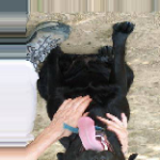
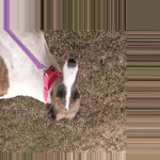
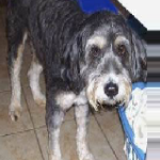
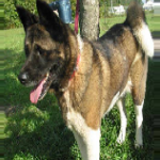
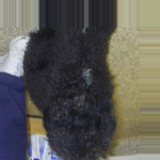


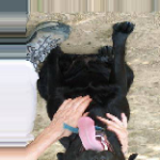
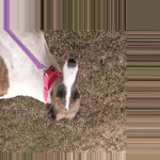
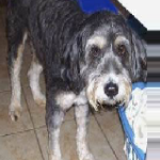
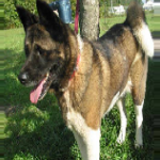
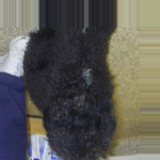


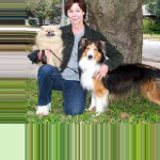
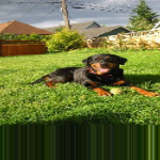
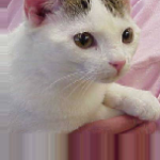
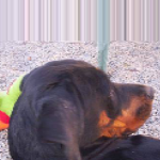
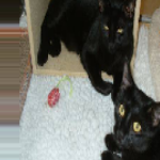


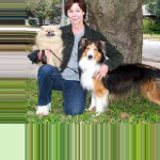
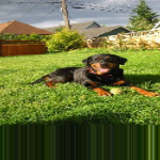
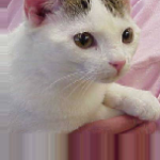
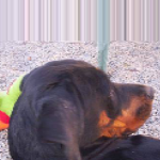
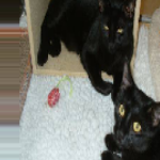


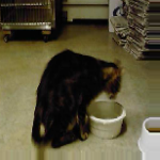
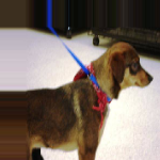
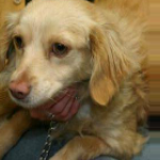
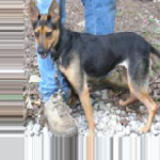
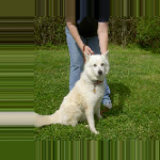


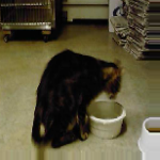
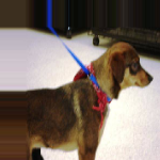
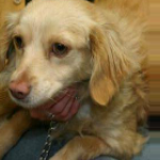
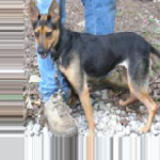
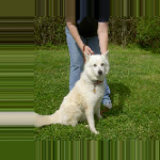


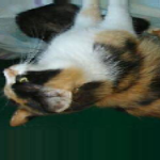
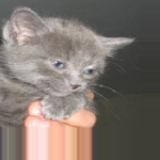
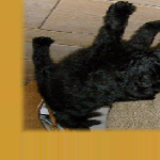
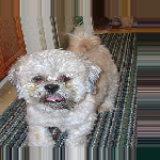
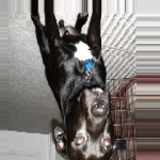


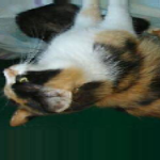
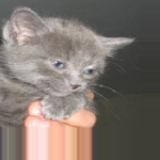
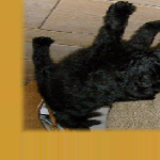
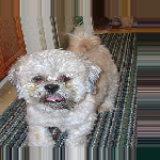
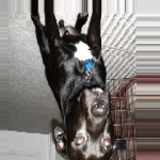


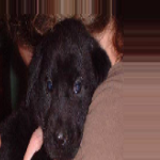
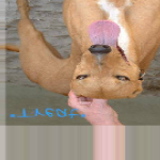
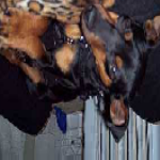
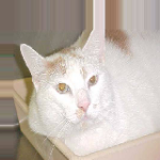
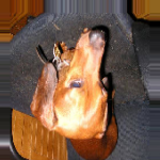


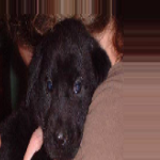
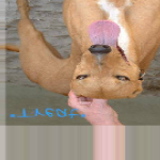
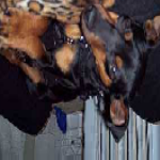
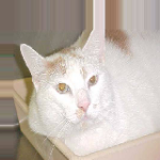
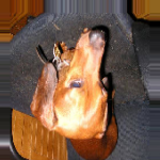


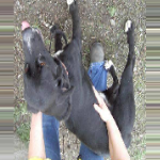
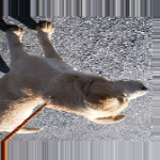
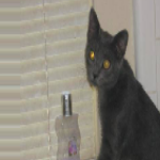
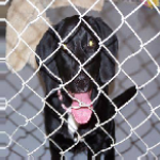
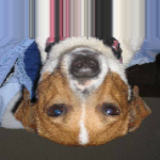


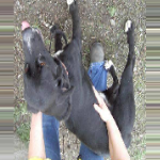
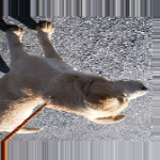
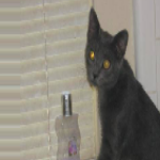
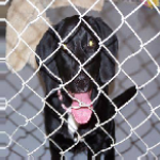
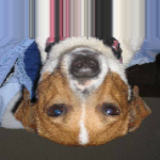


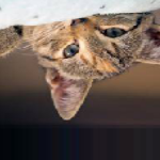
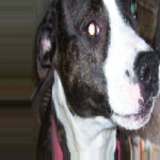
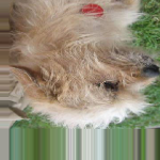
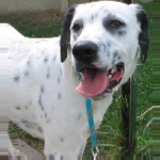
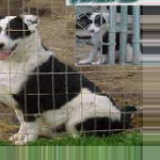


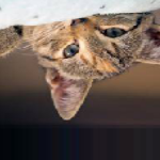
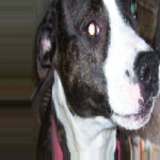
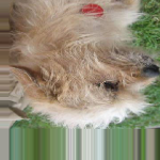
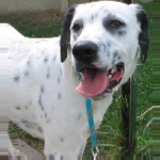
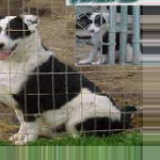


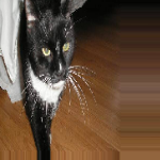
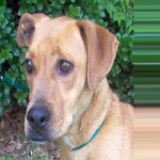
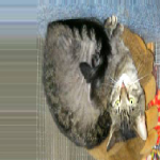
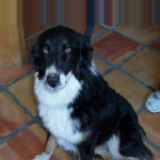
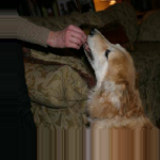


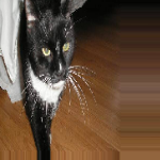
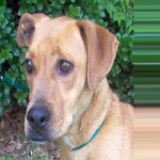
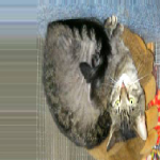
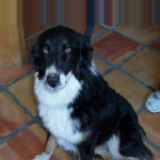
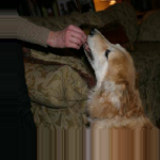


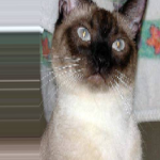
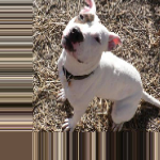
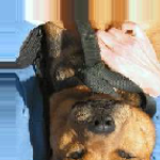
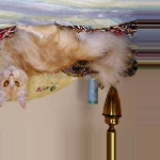
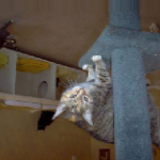


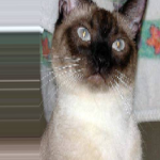
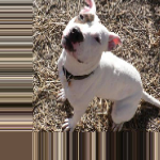
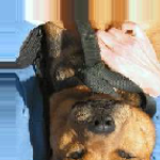
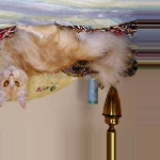
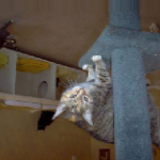


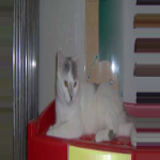
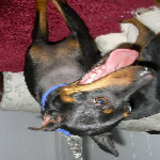
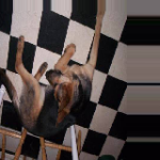
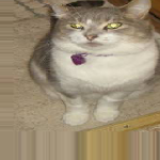
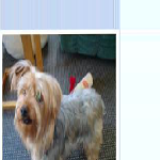


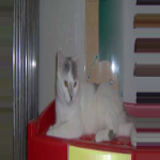
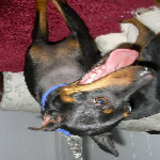
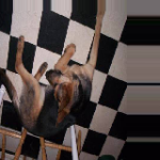
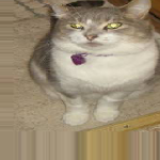
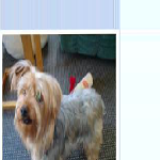

In [8]:
# Inspect augmentation
for _ in range(10):
    batch = train_data.next()[0]
    ipyplot.plot_images(batch[:5], img_width=160)


# Create model

We tried to create a vgg16 type network, where the filter size, and the number of convolution layers increases
while the pooling layers decreese the feature maps' size.
the pooling layer sizes were selected as 2, 3, 5
with the idea of reducing the featuremap sizes from 150 to 75, to 25 and then to 5
finally a global pooling, (in this case equal to an other pooling layer of size 5)

BatchNormalization layers should make the learning prcess faster, and reduce
the amount on noise learned by lowering the mean activation and activation standard deviation

we used dropout layers to reduce overfitting

In [9]:
def create_model():
    model = keras.Sequential([

        layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(imageSizeX, imageSizeY, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.BatchNormalization(),
        layers.Dropout(0.4),


        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(3,3),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(5,5),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.4),


        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),    

        layers.Dense(1, activation ='sigmoid')
    ])
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
        
    return model

In [10]:
# stops the training at given training accuracy
class myCallback(keras.callbacks.Callback):
    targetAccuracy = 0.9
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > (self.targetAccuracy)):   
            self.model.stop_training = True

# Train model

In [ ]:
def train_model(train_data, val_data, all_data):
    global patience

    model = create_model()

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    
    cb = keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    training_history = model.fit(
        train_data,
        epochs=1000, #we stop training the model with early stopping
        validation_data=val_data,
        callbacks=[cb, tensorboard_callback]
    )
    
    
    # after the training on the training dataset is done, we attempt to learn on the validation data + training data
    # until we reach the same training accuracy as we did on the training data
    cb = myCallback()
    cb.targetAccuracy = history.history['accuracy'][-(patience+1)]
    model.fit(
        all_data,
        epochs=1000, 
        callbacks=[cb]
    )
    
    model.save('cats_dogs_model1.h5')
    return (model, training_history)


In [ ]:
%tensorboard --logdir logs

In [ ]:
model, hist = train_model(train_data, val_data, all_data)

Reusing TensorBoard on port 6006 (pid 158), started 0:01:01 ago. (Use '!kill 158' to kill it.)

Epoch 1/1000
 1/75 [..............................] - ETA: 0s - loss: 1.1241 - accuracy: 0.4062WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
75/75 [==============================] - 17s 227ms/step - loss: 0.8182 - accuracy: 0.5100 - val_loss: 0.7275 - val_accuracy: 0.5000
Epoch 2/1000
75/75 [==============================] - 17s 222ms/step - loss: 0.7548 - accuracy: 0.5442 - val_loss: 0.7016 - val_accuracy: 0.5622
Epoch 3/1000
75/75 [==============================] - 17s 222ms/step - loss: 0.7203 - accuracy: 0.5629 - val_loss: 0.8512 - val_accuracy: 0.5022
Epoch 4/1000
75/75 [==============================] - 17s 220ms/step - loss: 0.6838 - accuracy: 0.5938 - val_loss: 0.9610 - val_accuracy: 0.5000
Epoch 5/1000
75/75 [==============================] - 17s 22

In [171]:
print("Average test loss: ", np.average(hist.history['loss']))


Average test loss:  0.24219970878958702


# Evaluation

In [168]:
test_loss, test_acc = model.evaluate(test_data, verbose=2)

5/5 - 0s - loss: 0.1860 - accuracy: 0.9533


In [130]:
probability_model = tf.keras.Sequential([model, layers.Softmax()])

In [132]:
predictions = probability_model.predict(test_data)